# Introduction to `pandora-sat`

`pandora-sat` is a simulator for Pandora data that is currently under development. 

In [23]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
plt.style.use('seaborn-white')

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_43061/2446044108.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


You can initialize the observatory using

In [25]:
c = SkyCoord.from_name('GJ 436')

In [124]:
p = ps.PandoraSat(ra=c.ra, dec=c.dec, theta=10*u.deg)

In [125]:
p

Pandora Sat (RA: 175.546 deg, Dec: 26.707 deg, theta: 10.0 deg)

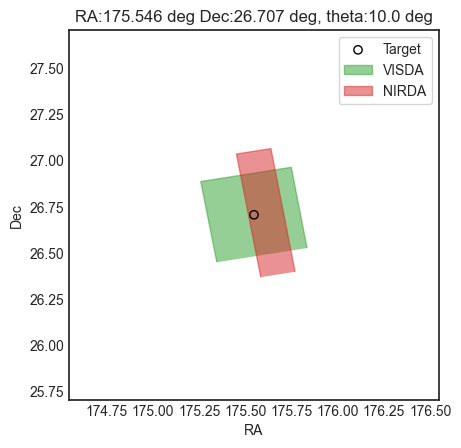

In [126]:
fig = p.footprint_plot();

You can see different detectors of the observatory using

In [122]:
nirda = p.NIRDA
visda = p.VISDA

## Basic Detector Properties

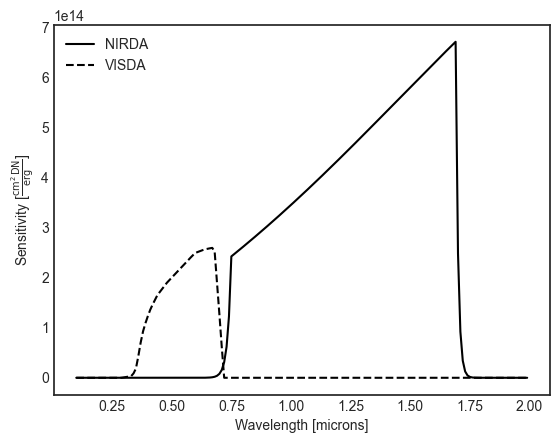

In [37]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

You can estimate the flux/magnitude of a source

In [38]:
nirda.flux_from_mag(10)

<Quantity 3.63869248e-14 erg / (Angstrom cm2 s)>

In [39]:
visda.flux_from_mag(10)

<Quantity 3.76036826e-13 erg / (Angstrom cm2 s)>

In [40]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.90236338>

In [41]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.43807595>

Detector have properties

In [42]:
visda.dark

<Quantity 1. electron / s>

In [43]:
visda.read_noise

<Quantity 1.5 electron>

## CH: ADD NIRDA NOISE PROPERTIES

You can take a look at the PSFs and PRFs for each detector with the `diagnose` function

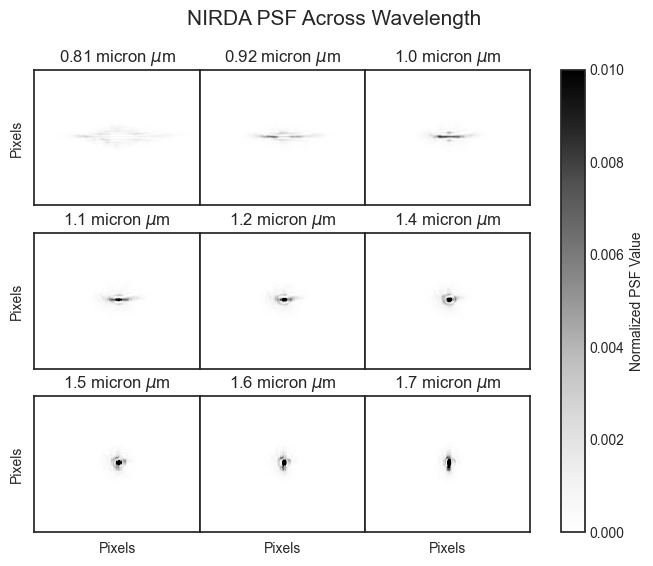

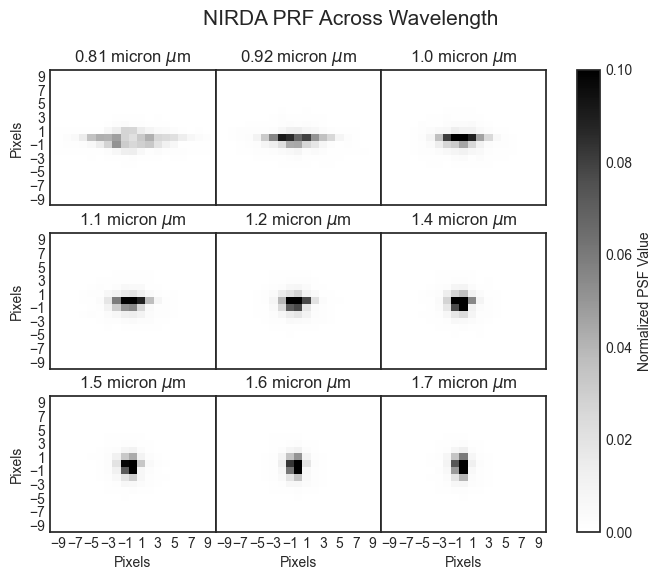

In [44]:
nirda.diagnose(n=3, image_type='psf');
nirda.diagnose(n=3, image_type='prf');

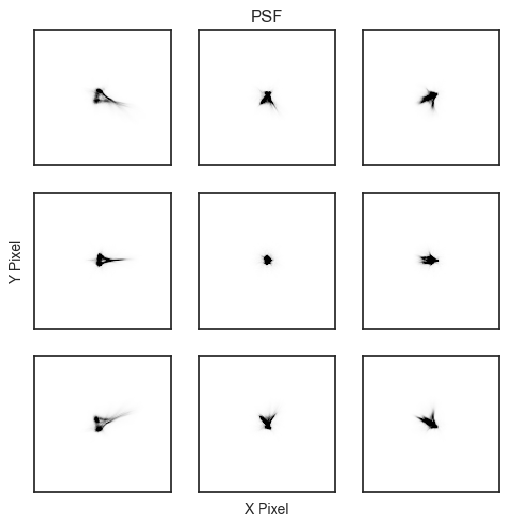

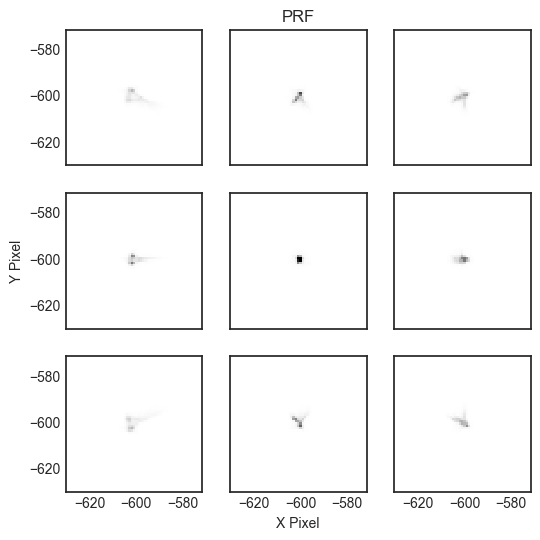

In [45]:
visda.diagnose(n=3, image_type='psf');
visda.diagnose(n=3, image_type='prf');

## Targets

To make simulations you'll need targets with information about the SED. You can get those either using:


In [46]:
target = ps.Target('GJ 436').from_vizier()

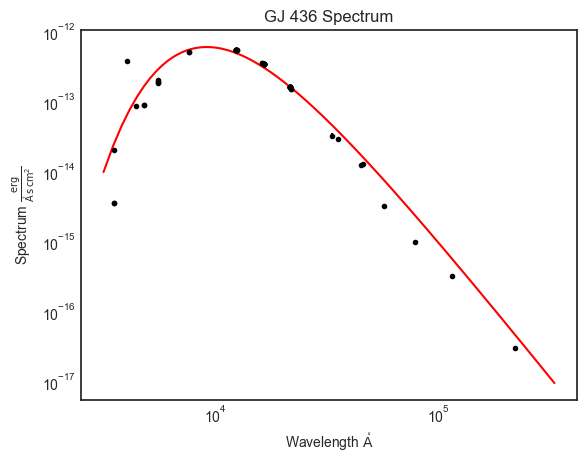

In [47]:
target.plot_spectrum();

or

In [111]:
target = ps.Target('GJ 436').from_phoenix()

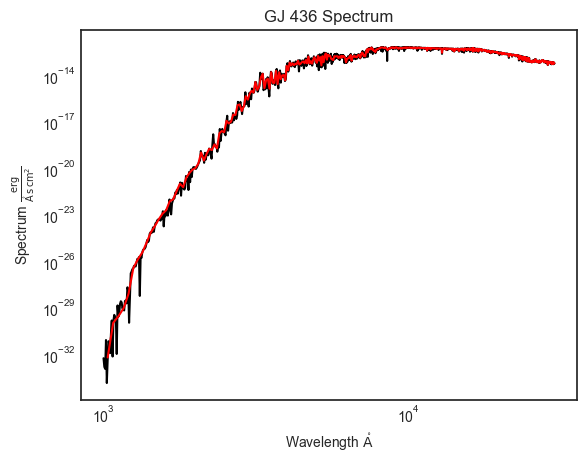

In [112]:
target.plot_spectrum();

`targets` have some helpful attributes including

In [50]:
target.ra

175.54622244662

In [51]:
target.dec

26.706571692

In [52]:
target.teff

3456.0

In [53]:
target.jmag

6.900000095367432

In [54]:
target.tmag

8.402999877929688

## Making Visible Image Simulations

To make image simulations you need to point the observatory at a target and get the sky catalog

In [68]:
# the observatory has the `get_sky_catalog` method for now
source_catalog = p.get_sky_catalog(p.ra, p.dec, p.theta)

In [69]:
source_catalog.head()

,ra,dec,mag,vis_row,vis_column,nir_row,nir_column,vis_counts,vis_flux
0,175.546222,26.706572,10.9173,1023.008916,1023.002508,1023.005888,79.001644,111358.637859,1.615513e-13
1,175.531056,26.702655,15.6036,1016.010251,958.278415,1018.385772,36.577503,1486.633483,2.156703e-15
2,175.550342,26.768722,11.6207,1301.277696,1089.551256,1204.806284,122.632691,58259.118611,8.451823e-14
3,175.594407,26.666592,15.9639,805.907038,1186.658822,880.149643,186.262561,1066.802218,1.547642e-15
4,175.584515,26.760296,10.7292,1238.497414,1221.519428,1163.611065,209.149535,132423.148659,1.921102e-13


In [70]:
len(source_catalog)

81

You can then get an image of the sky on the visible camera

In [84]:
# The observatory get's the sky image because eventually it will return images from both detectors.
nreads = 4
time, rowj, colj, thetaj, science_image = p.get_sky_images(p.ra, p.dec, p.theta, nreads=nreads, include_noise=True)

Below is a plot of the VISDA sky image. In future, this will also great a NIRDA image.

In [103]:
rowj[0].value

1.0781821684819302

(0.0, 2048.0)

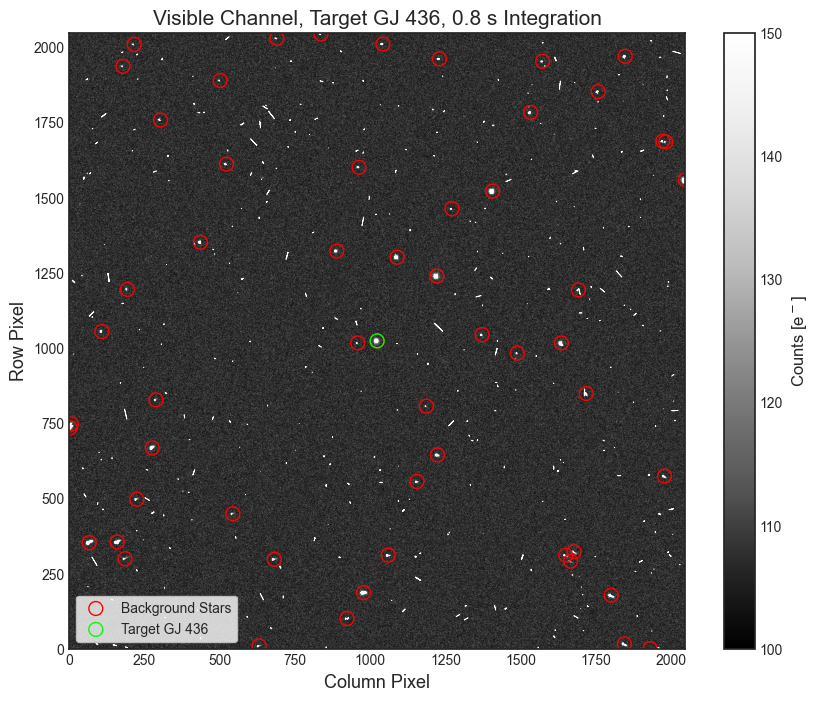

In [106]:
plt.figure(figsize=(10, 8))
plt.imshow(science_image[0].value, origin='lower', vmin=100, vmax=150, cmap='Greys_r')
cbar = plt.colorbar()
cbar.set_label('Counts [e$^-$]', fontsize=12)
plt.title(f'Visible Channel, {target}, {visda.integration_time*nreads} Integration', fontsize=15)
plt.xlabel("Column Pixel", fontsize=13)
plt.ylabel("Row Pixel", fontsize=13)
plt.scatter(source_catalog.vis_column, source_catalog.vis_row, edgecolor='r', facecolor='None', s=100, label='Background Stars')
plt.scatter(source_catalog.vis_column[0], source_catalog.vis_row[0], edgecolor='lime', facecolor='None', s=100, label=f'{target}')
plt.legend(frameon=True)
plt.xlim(0, visda.shape[0])
plt.ylim(0, visda.shape[1])

# Making NIRDA Traces

You can get an example trace of a target on the NIRDA detector using a

In [118]:
wavelength = np.linspace(0.1, 2, 6000) * u.micron
spectrum = target.model_spectrum(wavelength)
trace = nirda.get_trace(wavelength, spectrum, pixel_resolution=2)

OutOfBoundsError: Point (0.8001646196921808 micron) out of wavelength bounds.

[Text(0.5, 0, 'Pixels'), Text(0, 0.5, 'Pixels')]

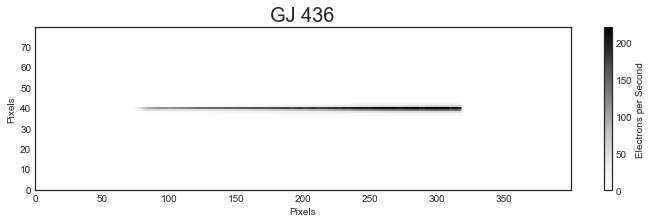

In [34]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.pcolormesh(np.arange(trace.shape[1]), np.arange(trace.shape[0]), trace.value)
cbar = plt.colorbar()
cbar.set_label("Electrons per Second")
plt.title('GJ 436', fontsize=20)
ax.set(xlabel='Pixels', ylabel='Pixels')

# Making realistic data simulations

In [35]:
target = ps.Target('HAT-P-19').from_phoenix()

Find the time baseline for observations

In [36]:
# Set a number of frames
nframes = 40
exptime = nframes * nirda.frame_time
time = np.arange(target.planets['b']['pl_tranmid'].value - 0.3, target.planets['b']['pl_tranmid'].value + 0.3, exptime.to(u.day).value)

# Drop some parts of the orbit because of Earth occultation
c = (90*u.minute).to(u.day).value
time = time[((time % c) > c * 0.3)]
cyc = time - (time % c)
time = time[(cyc != np.unique(cyc)[0]) & (cyc != np.unique(cyc)[-1])]

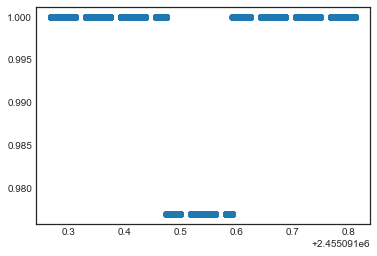

In [37]:
plt.scatter(time, target.box_transit(time))

In [38]:
integration = nirda.get_integration(wavelength, spectrum, nframes=nframes)

100%|███████████████████████████████████████████| 40/40 [00:17<00:00,  2.26it/s]


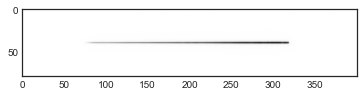

In [39]:
plt.imshow(integration)

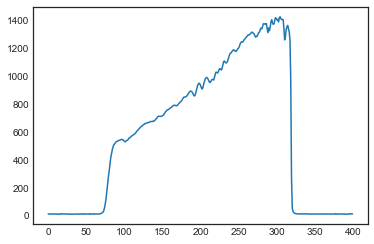

In [40]:
plt.plot(integration[38:42].mean(axis=0))

In [41]:
%load_ext line_profiler

In [948]:
%lprun -f nirda.psf.prf nirda.get_trace(wavelength, spectrum.value**0 * spectrum.unit, target_center=[40, 250])

Timer unit: 1e-06 s

Total time: 0.464871 s
File: /Users/chedges/repos/pandora-sat/src/pandorasat/psf.py
Function: prf at line 151

Line #      Hits         Time  Per Hit   % Time  Line Contents
   151                                               def prf(self, point, location=None, freeze_dimensions=None):
   152                                                   """
   153                                                   Bins the PSF down to the pixel scale.
   154                                           
   155                                                   Parameters
   156                                                   ----------
   157                                                   point: tuple
   158                                                       The point to interpolate at, in `self.dimension_names`
   159                                                   location: tuple
   160                                                       The location in pixels on the

In [1071]:
nx, ny = 8, 8
xcs, ycs = np.linspace(-0.5, 0.5, nx + 1)[:-1], np.linspace(-0.5, 0.5, ny + 1)[:-1]
psfs = np.zeros((nx, ny, 80, 50))
for idx, xc in tqdm(enumerate(xcs), position=0, leave=True, total=nx):
    for jdx, yc in enumerate(ycs):
        x1, y1, f = nirda.psf.prf(nirda.psf.midpoint, location=[40+yc, 25+xc])
        X, Y = np.asarray(np.meshgrid(x1, y1)).astype(int)
        psfs[idx, jdx, X, Y] = f.T

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 161.05it/s]


In [1115]:
x1 = (np.arange(0, 300)[:, None] + xcs).ravel()
idxs = (np.arange(nx)[None, :] + np.ones(300)[:, None]).astype(int).ravel()

In [1125]:
ar = np.zeros((80, 400))
k = np.where(ycs == 0)[0][0]
for idx in range(300):
    ar[:, idx:50+idx] += psfs[:, k].sum(axis=0)

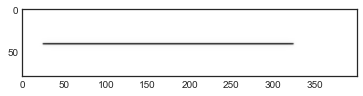

In [1126]:
plt.imshow(ar)

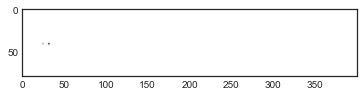

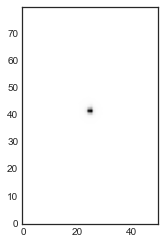

In [1122]:
plt.imshow(psfs[:, k].sum(axis=(0)), origin='lower')

/Users/chedges/Library/Caches/pypoetry/virtualenvs/pandorasat-O34My1_v-py3.9/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


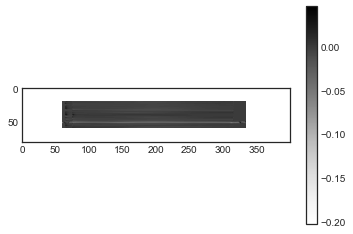

In [915]:
plt.imshow((trace1 - trace2)/trace1)
plt.colorbar()